---
syncID: 9bf062c33697432790b63db187cbc565
title: "Introduction to NEON Discrete Lidar Data in Python"
description: "Programmatically download lidar data and metadata and explore discrete lidar point clouds and rasters in Python"
dateCreated: 2022-09-24
authors: Bridget Hass
contributors: 
estimatedTime: 45 minutes - 1 hour
packagesLibraries: requests, json, gdal, geopandas, laspy, lasrs
topics:
languagesTool: python
dataProduct: DP3.10003.001, 
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/Lidar/intro-lidar/intro_point_clouds_py/intro_discrete_point_clouds.py
tutorialSeries: 
urlTitle: neon-discrete-point-clouds
---

<div id="ds-objectives" markdown="1">

### Objectives
After completing this tutorial, you will be able to:

* Use Python functions to programmatically download NEON AOP data from the API
* Download and plot shapefiles and kmls (included as lidar metadata) to visualize coverage for a given year
* Explore and plot the AOP discrete lidar point cloud contents in Python using the `laspy` package
* Read in and plot the AOP L3 raster data products (CHM, DTM, DSM) in Python using the `rasterio` package 

### Requirements

To follow along with this code, you will need to install **Python 3.x**. This tutorial was developed using Python 3.9, so if you are installing Python for the first time, we recommend that version. 

We recommend following along in **Jupyter Notebooks** so you can run each cell "chunk" individually, although you can also use a different IDE (Interactive Development Environment) of your choice. If not using **Jupyter**, we recommend using **Spyder**, which has similar functionality. 

* **Install Python 3.x and Jupyter Notebooks** 
You can install both Python, Jupyter Notebooks, and Spyder by downloading <a href="https://www.anaconda.com/products/distribution" target="_blank">Anaconda</a>.

* **Install required Python packages**

    * requests
    * gdal
    * fiona
    * geopandas
    * rasterio
    * laspy
    * lazrs

    More detailed installation instructions are provided below.

* **Download the script** <a href="./neon_aop_download_functions.py" download="neon_aop_download_functions.py">neon_aop_download_functions.py</a> and save it in your working directory.

* **Try out Jupyter Notebooks**

If you are new to using Jupyter Notebooks, please run through the tutorial below to familiarize yourself with the Notebook environment: <a href="https://www.neonscience.org/resources/learning-hub/tutorials/jupyter-python-notebook" target="_blank">Introduction to Using Jupyter Notebooks</a>

#### Python Installation Tips: 

Most of the required packages can be installed using `pip install` or `conda install`. To install `gdal`, in the command line, run:

```python
pip install gdal
```

Within Jupyter notebooks (or the Spyder Console) you can also install packages directly, but have to include an `!` before the statement, which runs a shell command (as you would from a command prompt):

```python
!pip install gdal
```

**Installation Tips for Mac Users:**

For Python 3.9, if pip does not successfully install gdal, try running `conda install gdal` in the terminal. 

**Installation Tips for Windows Users:**

For many of the geospatial packages (eg. gdal, fiona, geopandas, rasterio), there may be errors installing on your version of Python using the standard `pip install`. You may need to find the package wheel file specific to your version of Python and your computer. A fairly comprehensive archive of these geospatial (and other) wheel files can be found here:

https://www.lfd.uci.edu/~gohlke/pythonlibs/

For example, to install `gdal` on a windows 64 machine, using Python 3.9, download the file GDAL-3.4.3-cp39-cp39-win_amd64.whl, found here (you can also find this by navigating through the link above, clicking on gdal in the list of packages at the top):

https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal

Then install with `pip` as follows:

```python
pip install C:\Users\username\Downloads\GDAL-3.4.3-cp39-cp39-win_amd64.whl
```

To confirm the installations worked properly, import each package separately, and make sure there are no error messages. You can also run this installation and set-up validation script.

### Additional Resources

If you are interested in learning more about the NEON API, or want a deeper dive in how this works with the Python `requests` package, please refer to the tutorial and webpages linked below.
 * <a href="https://www.neonscience.org/resources/learning-hub/tutorials/neon-api-01-introduction-requests" target="_blank"> Introduction to NEON API in Python </a>
 * <a href="https://data.neonscience.org/data-api/" target="_blank"> NEON Data API </a>

For a handy resource on Jupyter Notebook tips, tricks and shortcuts, check out the DataQuest blog linked below.
 * <a href="https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-sh" target="_blank"> 28 Jupyter Notebook Tips, Tricks, and Shortcuts </a>

</div>

## Overview of AOP Discrete Lidar Data Products

AOP generates several Level-1 and Level-3 (derived) data products. The Level 1 lidar data is the point cloud data, provided in laz (or zipped las) format, while the Level 3 data is provided in geotiff (.tif) raster format. Images of these two data types are shown in the figures below.

<figure>
    <a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/py-figs/intro-point-clouds-py/AOP-WREF-discrete-point-lidar-forest.png">
    <img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/py-figs/intro-point-clouds-py/AOP-WREF-discrete-point-lidar-forest.png" width="600"/>Lidar Point Cloud</a>
    <figcaption="Example Lidar Point Cloud, colorized by elevation and RGB camera imagery"</figcaption>
</figure>

<figure>
    <a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/py-figs/intro-point-clouds-py/L3-raster.png">
    <img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/py-figs/intro-point-clouds-py/L3-raster.png" width="300"/>Lidar Elevation Raster</a>
    <figcaption="Example Lidar Elevation Raster"</figcaption>
</figure>

The table below summarizes the NEON AOP Lidar data products. This lesson will give a brief introduction to both the Level 1 Classified Point Cloud data, as well as the Level 3 raster geotiff data products (DTM, DSM, and CHM). For more detailed information on these data products, please refer to: <a href="https://www.neonscience.org/data-collection/lidar" target="_blank"> Airborne Remote Sensing Lidar</a>, and/or click on the linked data product pages in the table. 

| Acronym / Short Name | Data Product Name | Data Product ID | Link to ATBD |
|---------|-------------------|-----------------|--------------|
| Point Cloud | Discrete return LiDAR point cloud | <a href="https://data.neonscience.org/data-products/DP1.30003.001" target="_blank">DP1.30003.001</a> | <a href="https://data.neonscience.org/api/v0/documents/NEON.DOC.001292vB" target="_blank">NEON L0-to-L1 Discrete Return LiDAR ATBD</a>|
| CHM | Ecosystem structure | <a href="https://data.neonscience.org/data-products/DP3.30015.001" target="_blank">DP3.30015.001</a> | <a href="https://data.neonscience.org/api/v0/documents/NEON.DOC.002387vA" target="_blank">NEON Ecosystem Structure ATBD</a>|
| DSM/DTM | Elevation - LiDAR| <a href="https://data.neonscience.org/data-products/DP3.30024.001" target="_blank">DP3.30024.001</a> | <a href="https://data.neonscience.org/api/v0/documents/NEON.DOC.002390vA" target="_blank">NEON Elevation (DTM and DSM) ATBD</a> |
| Slope/Aspect | Slope and Aspect - LiDAR | <a href="https://data.neonscience.org/data-products/DP3.30025.001" target="_blank">DP3.30025.001</a> | <a href="https://data.neonscience.org/api/v0/documents/NEON.DOC.003791vA" target="_blank">NEON Elevation (Slope and Aspect) ATBD</a> |

The Data Product page contains important information, as well as linked Algorithm Theoretical Basis Documents (ATBDs) which provide necessary information for understanding how the data products were generated, uncertainty associated with the data, and other essential contextual information.


### Lidar Point Clouds

The first part of this tutorial will be working with the Discrete Return LiDAR Point Cloud data product (<a href="https://data.neonscience.org/data-products/DP3.30003.001" target="_blank">DP3.30003.001</a>) at the NEON site <a href="https://www.neonscience.org/field-sites/guan" target="_blank">Guanica Forest (GUAN)</a> in Domain 04, Puerto Rico.

Before we dig into the data, we'll need to import the required packages.

#### Import Packages

First, we need to import the required Python packages. 

**Reminder**: If you haven't installed these packages (see more detailed installation instructions above), you can install them in the notebook as shown below. If the install doesn't work with a simple pip install, download the appropriate wheel file and substitute the package name with the wheel file name (including the full path). We recommend installing these packages one by one so you can make sure each package installs successfully.

```python
!pip install requests
!pip install gdal
!pip install fiona
!pip install geopandas
!pip install rasterio
!pip install laspy
!pip install lazrs
```

Once all packages are successfully installed, import them as follows. Note that `requests` and `json` will be imported when we import the separate module (script), so you don't need to import those separately.

In [1]:
#import required packages
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import laspy

Now we'll pull in all the functions in the module **neon_aop_download_functions.py**, linked at the top of this tutorial. 

First make sure this script is saved in your working directory, which we can check by navigating into that directory, or by using `os.listdir`. If you haven't saved it in your working directory, you will need to provide the relative path to this script when importing.

```python
# check that script is saved in same folder:
os.listdir()
```

Once you've confirmed that the `neon_aop_download_functions script` is in your working directory, you can import the contents of this file as follows:

In [2]:
from neon_aop_download_functions import *

Alternatively, if you'd like to see the contents of that file in your notebook, you can use the "magic" command `%load` as follows:

```python
%load neon_aop_download_functions.py
```

If you go this route, you will need to run the cell twice for the functions to be read into the notebook. The first run will load the functions into the cell, and the second run will load the functions into the working environment. This option of loading in the functions may be useful if you wish to modify the functions locally, eg. according to your specific workflow.

Now that we've imported in all the required packages and functions, we can get started! First let's take a look at what exactly we've imported by using the magic command `%whos`. Since there is no variable explorer in Jupyter Notebooks, this is a quick way to see the contents (variables, functions, modules, etc.) that have been loaded in our current environment.

In [3]:
%whos

Variable                      Type        Data/Info
---------------------------------------------------
download_aop_files            function    <function download_aop_fi<...>es at 0x0000029671BA80D0>
download_file                 function    <function download_file at 0x0000029671B9DF70>
download_urls                 function    <function download_urls at 0x0000029671B9DEE0>
get_file_size                 function    <function get_file_size at 0x0000029671BA8040>
gpd                           module      <module 'geopandas' from <...>\geopandas\\__init__.py'>
laspy                         module      <module 'laspy' from 'C:\<...>ges\\laspy\\__init__.py'>
list_available_urls           function    <function list_available_<...>ls at 0x000002966D323F70>
list_available_urls_by_year   function    <function list_available_<...>ar at 0x0000029671B9DE50>
np                            module      <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
os                            module     

#### Data Tip
If you are unsure what a function or module does, you can find more information about the function in two ways: 
1. type `help(function_name)`, which will print out documentation below the cell, or
2. type the function name followed by `?`, which will pop up the documentation at the bottom of your Jupyter Notebook window, and you can then exit out of it at your convenience

```python
help(requests)
requests?
```

The functions loaded from the `neon_aop_download_functions.py` file also include similar documentation, so you can also use the help function with for user-defined functions, as long as the appropriate `docstrings` (comments) have been added.

```python
help(list_available_urls)
list_available_urls?
```

Now that we've pulled in the packages needed for the first part of the tutorial, we can download a dataset from the NEON API.

First we'll start by defining variables that specify the NEON data product ID (`dpID`), site, and year. You can change the site code to look at a different site of your interest (for more detailed information about the NEON sites, please check out the <a href="https://www.neonscience.org/field-sites/explore-field-sites" target="_blank">Explore Field Sites</a> webpage. 

In [4]:
dpID='DP1.30003.001' 
site = 'GUAN'

We can use the function `list_available_urls` to see what data is available for this data product and site. This function requires two inputs: the data product ID `dpID` and the site ID, `site`.

In [5]:
help(list_available_urls)

Help on function list_available_urls in module neon_aop_download_functions:

list_available_urls(product, site)
    list_available urls lists the api url for a given product and site
    --------
     Inputs:
         product: the data product code (eg. 'DP3.30015.001' - CHM)
         site: the 4-digit NEON site code (eg. 'SRER', 'JORN')
    --------
    Usage:
    --------
    jorn_chm_urls = list_available_urls('DP3.30015.001','JORN')



In [6]:
list_available_urls(dpID,site)

['https://data.neonscience.org/api/v0/data/DP1.30003.001/GUAN/2018-05']

The AOP has only flown Puerto Rico (D04) once so far, in 2018. D04 is only on the AOP schedule every 4 years; the next campaign is scheduled for the fall of 2022, so new data is expected relatively soon!

Next let's set up some paths where we can save our downloaded data. We'll start with downloading geospatial metadata in order to get a sense of the coverage (geographic extents) of the flight area. We'll make a folder for the shapefiles (shp), kml files (which may be useful for interactively looking at the site boundaries in Google Earth), and a folder for the actual lidar (laz) data.

In [7]:
year='2018'
data_root_path = './data/'+site+'/'+year+'/'
shp_path = data_root_path+'shp/'
kml_path = data_root_path+'kml/'
laz_path = data_root_path+'laz/'
print(data_root_path)

./data/GUAN/2018/


Next, let's take a look at the `download_aop_files` function, which we'll use to download the metadata and data that we want to explore.

In [8]:
help(download_aop_files)

Help on function download_aop_files in module neon_aop_download_functions:

download_aop_files(product, site, year=None, download_folder='./data', match_string=None, check_size=True)
    download_aop_files downloads NEON AOP files from the AOP for a given data product, site, and 
    optional year, download folder, and 
    --------
     Inputs:
         required:
             product: the data product code (eg. 'DP3.30015.001' - CHM)
             site: the 4-digit NEON site code (eg. 'SRER', 'JORN')
         
         optional:
             year: year (eg. '2020'); default (None) is all years
             download_folder: folder to store downloaded files; default (./data) in current directory
             match_string: subset of data to match, need to use exact pattern for file name
             check_size: prompt to continue download (y/n) after displaying size; default = True
    --------
    Usage:
    --------
    download_aop_files('DP3.30015.001','JORN','2019','./data/JORN_2019/

The only required inputs for this function are the `product` and the `site`; optionally we can specify the `year`, the `download_folder` to save the files, and a `match_string` to download a subset of the data by a string. By default, the function will display the size of the files, and prompt the user to continue the download (by typing `y`); any other response will halt the download. This is to prevent an accidental download of a large volume of data.

### Lidar Metadata

We'll start by downloading the some of the metadata, including the pdf documentation, and shape files that provide geographic information corresponding to the data. Because AOP data can be pretty large for an entire site, and you may only need to work with a subset of the data for a given site, we recommend starting with downloading only the metadata. 

#### Lidar Documentation - QA pdfs

AOP data provides summary pdf documents, which include important information about the sensors used to collect the lidar data, acquisition parameters, processing parameters, and QA information. When working with any AOP data, we recommend reviewing this documentation, as well as referencing the relevant ATBDs.

In [9]:
#download the QA reports to the default download directory (./data)
download_aop_files(dpID,site,year,match_string='.pdf',check_size=False)

Download size: 11.29 MB
downloading 2018_GUAN_1_L3_discrete_lidar_processing.pdf to ./data
downloading 2018_GUAN_1_V01_LMS_QAQC.pdf to ./data


Please take a look at these pdfs on your own time!

#### Download and Plot Shapefile Boundaries

There are summary shape files provided along with the lidar data for each site. These summary files end with `merged_tiles.shp/.shx`, so we can key off that string to download only the full boundary shape file. You could also download all of the individual `.shp` files for each data tile (L3 data is provided in 1km x 1km tiles), by using the match string `.shp`, or similarly all the `.kml` files, if you wanted to pull the data boundaries into Google Earth and explore more interactively.

We'll download the merged_tiles shapefiles (you need to download both extensions .shp and .shx):

In [10]:
#download the full-boundary shape files
download_aop_files(dpID,site,year,shp_path,'merged_tiles.shp',check_size=False)
download_aop_files(dpID,site,year,shp_path,'merged_tiles.shx',check_size=False)

Download size: 0.78 kB
downloading 2018_GUAN_1_merged_tiles.shp to ./data/GUAN/2018/shp/
Download size: 0.0 kB
downloading 2018_GUAN_1_merged_tiles.shx to ./data/GUAN/2018/shp/


We can see that these files have downloaded to the expected location by listing the contents of the `shp_path` directory that we've made:

In [11]:
os.listdir(shp_path)

['2018_GUAN_1_merged_tiles.shp', '2018_GUAN_1_merged_tiles.shx']

We can see these files in the `shp` directory we created. Next, let's plot the boundary shapefile data using `geopandas` (imported as `gpd`) as follows:

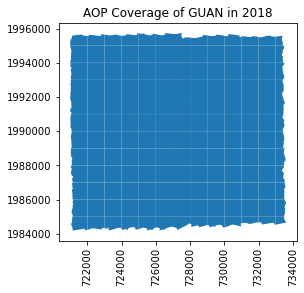

In [12]:
gdf = gpd.read_file(os.path.join(shp_path,'2018_GUAN_1_merged_tiles.shp'))
gdf.plot();
ax = plt.gca(); ax.ticklabel_format(style='plain') 
ax.set_title('AOP Coverage of ' + site + ' in ' + year);
plt.xticks(rotation=90); #optionally rotate the xtick labels

We can also pull in the boundary kml file, which can be pulled into Google Earth for a more interactive experience.

In [13]:
download_aop_files(dpID,site,year,kml_path,'full_boundary.kml',check_size=False) 

Download size: 0.13 kB
downloading full_boundary.kml to ./data/GUAN/2018/kml/


If you pull this into Google Earth you can see the coverage with more geographic context:

<figure>
    <a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/py-figs/intro-point-clouds-py/guan_boundary_google_earth.PNG">
    <img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/py-figs/intro-point-clouds-py/guan_boundary_google_earth.PNG" width="400"/>GUAN kml boundary</a>
    <figcaption="KML boundary of GUAN"</figcaption>
</figure>

Now that we can see the extent of the tiles, we'll pick a single tile in this area to download. For this example, I'll choose the tile "724000_1985000" towards the southern part of the site, including both land and sea.

In [14]:
download_aop_files('DP1.30003.001',site,year,laz_path,match_string='725000_1985000_classified_point_cloud_colorized.laz')

Download size: 18.0 MB
Do you want to continue with the download? (y/n) y
downloading NEON_D04_GUAN_DP1_725000_1985000_classified_point_cloud_colorized.laz to ./data/GUAN/2018/laz/


We can use `os.listdir` again to check that this file successfully downloaded to the expected location. Alternatively you could go into your file explorer.

In [15]:
os.listdir(laz_path)

['NEON_D04_GUAN_DP1_725000_1985000_classified_point_cloud_colorized.laz']

### Exploring point cloud data with `laspy`

Now that we've successfully downloaded a laz (or zipped las) file, we can use the `laspy` package to read it in! We'll do that in the next line, reading the lidar file into the variable name `point_cloud`:

In [16]:
# use os.path.join to get the full path of the laz file
laz_data_file=os.path.join(laz_path,'NEON_D04_GUAN_DP1_725000_1985000_classified_point_cloud_colorized.laz')
# read the laz file into a LasData object using laspy.read()
point_cloud=laspy.read(laz_data_file)

Reading in the file with with laspy.read() reads in both the metadata and the raw point cloud data. We can print out the `point_cloud` variable to show some basic information about what we've read in:

In [17]:
point_cloud

<LasData(1.3, point fmt: <PointFormat(3, 4 bytes of extra dims)>, 2968778 points, 2 vlrs)>

`point_format.dimension_names` show us the available information stored in this LasData object format:

In [18]:
list(point_cloud.point_format.dimension_names)

['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'synthetic',
 'key_point',
 'withheld',
 'scan_angle_rank',
 'user_data',
 'point_source_id',
 'gps_time',
 'red',
 'green',
 'blue',
 'reversible index (lastile)']

In the next few cells, we can explore some of these variables:

In [19]:
point_cloud.classification

<SubFieldView([2 2 2 ... 7 7 7])>

Let's get the `set` of this `list` to see all the unique classification values in this file. This may take a little time to run.

In [20]:
set(list(point_cloud.classification))

{1, 2, 5, 6, 7}

We can see that there are a several unique classification values for this site.
Las files have "predefined classification schemes defined by the American Society for Photogrammetry and Remote Sensing (ASPRS)". You can refer to the <a href="https://desktop.arcgis.com/en/arcmap/10.3/manage-data/las-dataset/lidar-point-classification.htm" target="_blank">ArcGIS documentation</a> for more details.

The following table lists the LAS classification codes defined by ASPRS for these LAS versions:

| Classification value | Meaning           |
|---------------------|-------------------|
| 0                   | Never classified  |
| 1                   | Unassigned        |
| 2                   | Ground            |
| 3                   | Low Vegetation    |
| 4                   | Medium Vegetation |
| 5                   | High Vegetation   |
| 6                   | Building          |
| 7                   | Low Point         |

Next let's take a look at what we can consider to be the main data - the geographic loation of each point in the point cloud. This can be accessed either by `point_cloud.xyz`. Let's take a look:

In [21]:
point_cloud.xyz

array([[ 7.25894810e+05,  1.98500265e+06,  2.50000000e-01],
       [ 7.25915210e+05,  1.98500018e+06,  4.20000000e-01],
       [ 7.25893550e+05,  1.98500798e+06,  2.20000000e-01],
       ...,
       [ 7.25085510e+05,  1.98583553e+06, -1.80370000e+02],
       [ 7.25101320e+05,  1.98584004e+06, -2.37230000e+02],
       [ 7.25122790e+05,  1.98583813e+06, -3.05320000e+02]])

We can see this is a 3-dimensional array, as we might expect. Let's read this into the variable `xyz`:

In [22]:
xyz = point_cloud.xyz

We can see the size (or number of points) in this array using the built-in python function `len`:

In [23]:
len(xyz)

2968778

There are > 2 million lidar points in this single 1km x 1km tile. For the rest of this exercise, we'll look at a random subset of these points, taking every100th point (you can change this subset factor, but when we visualize the data in a few steps, subsetting by a larger factor will speed up the time it takes to make the plot).

In [24]:
factor=100
points_dec = xyz[::factor]

These point clouds have been "colorized" by the camera RGB imagery. If you refer back to the dimension names, you can see there are a `red`, `green`, and `blue` attributes. We can pull these into a single array by using `np.vstack`:

In [25]:
# points = np.vstack((point_cloud.x, point_cloud.y, point_cloud.z)).transpose()
colors = np.vstack((point_cloud.red, point_cloud.green, point_cloud.blue)).transpose()

These colors have been scaled to store the color at a higher resolution, accomodated by the camera, so we'll need to re-scale the values between 0-1 in order to use them in our plot. The code below does this re-scaling, and then subsets the color data to by same factor we used to subset the `xyz` data.

In [26]:
colors_norm = (colors - np.min(colors))/np.ptp(colors)
colors_dec = colors_norm[::factor]

### 3D Point Cloud Visualization 
Lastly, we can visualize this 3D data using matplotlib to see what the point cloud looks like. 

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

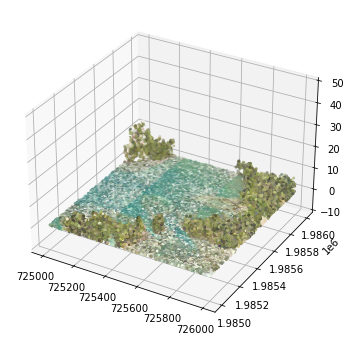

In [28]:
# Plot the las data in 3D
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_dec[:,0],points_dec[:,1],points_dec[:,2],color=colors_dec,s=4)
ax.set_zlim3d(-10,50)
plt.show()

We can see a mix of both land and sea here, with slightly fewer returns on the ocean. A lot of the energy from the laser beam is absorbed in water, so it is typical to see low density over bodies of water. Remember this plot only displays 1/100th of the data, so there is a lot more information stored in the las file than is shown here.

### Lidar Raster Data - DTM, DSM, and CHM

Lastly, we'll take a look at some of the derived (Level-3, or L3) data products generated from this point cloud data. NEON generates 5 different derived L3 products from the discrete data, summarized below. 

In the last part of this lesson, we'll show how to read in and visualize the CHM, DTM, and DSM data using the Python package `rasterio`. First we'll import the package and sub-package that's used to display the data

In [29]:
import rasterio
from rasterio.plot import show

In the next couple cells, we'll create a path to save the raster data, and then download the L3 CHM, DTM, and DSM geotiffs of the same tile as the point cloud file we downloaded earlier. You'll see the syntax here is the same, we are just using different data product IDs and match_strings with the appropriate extensions.

In [30]:
l3_path = data_root_path+'L3/'

In [31]:
download_aop_files('DP3.30015.001',site,year,l3_path,match_string='725000_1985000_CHM.tif',check_size=False)
download_aop_files('DP3.30024.001',site,year,l3_path,match_string='725000_1985000_DTM.tif',check_size=False)
download_aop_files('DP3.30024.001',site,year,l3_path,match_string='725000_1985000_DSM.tif',check_size=False)

Download size: 4.01 MB
downloading NEON_D04_GUAN_DP3_725000_1985000_CHM.tif to ./data/GUAN/2018/L3/
Download size: 4.01 MB
downloading NEON_D04_GUAN_DP3_725000_1985000_DTM.tif to ./data/GUAN/2018/L3/
Download size: 4.01 MB
downloading NEON_D04_GUAN_DP3_725000_1985000_DSM.tif to ./data/GUAN/2018/L3/


Next we'll read these in, using `rasterio`, as follows:

In [32]:
chm = rasterio.open(os.path.join(l3_path,'NEON_D04_GUAN_DP3_725000_1985000_CHM.tif'))
dtm = rasterio.open(os.path.join(l3_path,'NEON_D04_GUAN_DP3_725000_1985000_DTM.tif'))
dsm = rasterio.open(os.path.join(l3_path,'NEON_D04_GUAN_DP3_725000_1985000_DSM.tif'))

And finally, we can plot the data using the rasterio `show` function that we imported earlier.

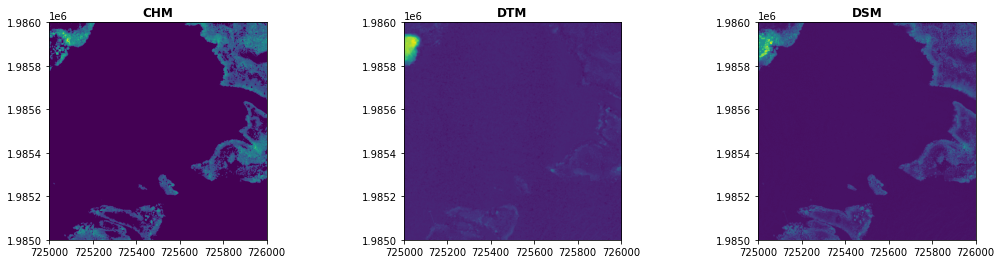

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
show((chm), ax=ax1, title='CHM');
show((dtm), ax=ax2, title='DTM');
show((dsm), ax=ax3, title='DSM');
plt.show;

## Additional Resources

* **L1 Point Clouds (.laz)**: If you'd like to continue exploring the point cloud data in Python using `laspy`, <a href="https://laspy.readthedocs.io/en/latest/complete_tutorial.html" target="_blank"> laspy website </a> has some nice examples you can follow, now that you know how to download NEON point cloud data and read it into Python.
* **L3 Rasters (.tif)**: Refer to the <a href="https://rasterio.readthedocs.io/en/latest/" target="_blank"> rasterio documentation </a> for more options on plotting, and beyond in rasterio.

### Python and Beyond - Other Options for working with Point Cloud Data

There are also a number of open-source tools for working with point-cloud data. Python may not be the best option for developing more rigourous processing workflows, for example. The resources below show some other recommended tools that can be integrated with Python for your analysis:

* <a href="https://rapidlasso.com/lastools/" target="_blank">LAStools</a>
* <a href="https://pdal.io/en/stable/" target="_blank">PDAL (Point Data Abstraction Library)</a> 
* <a href="https://plas.io/" target="_blank">plas.io (free, interactive, web-based point cloud visualization)</a> 
* <a href="https://r-lidar.github.io/lidRbook/" target="_blank"> lidR (R package for point cloud data)</a>